# Reservoir Simulation Notebook

Welcome to the Reservoir Simulator! This notebook models pressure distribution in a 2D reservoir with multiple wells. It is designed for engineers and students to understand and visualize reservoir behavior over time.

## How to Use This Notebook
- **Step 1:** Review the project overview and requirements below.
- **Step 2:** Set your simulation parameters in the next cell.
- **Step 3:** Run each cell in order to build the model, run the simulation, and visualize results.
- **Step 4:** Interpret the results using the provided plots and explanations.

---

## Requirements
- Python 3.8+
- numpy, scipy, matplotlib, plotly, pandas

To install requirements, run:
```bash
pip install numpy scipy matplotlib plotly pandas
```

---

## Project Overview
This notebook simulates pressure changes in a rectangular oil reservoir using finite difference methods. It supports multiple wells (producers/injectors) and visualizes pressure evolution in 3D and interactive plots.

---

## Workflow
1. **Set Parameters**: Define grid, reservoir, and well properties.
2. **Define Functions**: Core simulation and transmissibility functions.
3. **Run Simulation**: Calculate pressure distribution over time.
4. **Visualize Results**: View 3D and interactive plots.
5. **Interpretation**: Understand and analyze the output.

## This block of code sets the properties of the reservoir.  The commented code is for user input.  
The first block is where the user inputs the reservoir information.  Exchange the function with what's included here below in the triple-quotes to ask the user for their input.

In [8]:
import numpy as np
from scipy import sparse

'''
def Res_properties():
    NX = int(input("Number of X grid blocks: "))
    NY = int(input("Number of Y grid blocks: "))
    L = int(input("Length of Reservoir: "))
    W = int(input("Width of Reservoir: "))
    h = int(input("Height of Reservoir: "))
    rw = float(input("Wellbore radius: "))
    dt = float(input("Change in time: "))
    mu = float(input("Fluid viscosity: "))
    Bw = float(input("Formation volume factor: "))
    ct = float(input("Rock compressibility: "))
    Pi = int(input("Initial pressure: "))
    Porosity = (np.ones([NX, NY])*0.3).T
    Permeability = (np.ones([NX, NY])*75).T
    t = int(input("Total time: "))
    n = int(input("Number of wells: "))
    
    return NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n'''

def Res_properties():
    NX = 99
    NY = 99

    L = 20000
    W = 20000
    h = 300
    rw = float(.25)
    dt = float(1)
    mu = float(1)
    Bw = float(1.36)
    ct = float(1e-06)
    Pi = int(3000)
    Porosity = (np.ones([NX, NY])*.3).T
    Permeability = (np.ones([NX, NY])*75).T
    t = int(100)
    n = 5

    return NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()

dx = L/NX
dy = W/NY

Area_x = h*dx
Area_y = h*dy

## 1. Set Simulation Parameters

Edit the values in the next cell to configure your simulation. Each parameter is explained below:

- **NX, NY**: Number of grid blocks in X and Y directions (resolution)
- **L, W, h**: Reservoir length, width, and height (ft)
- **rw**: Wellbore radius (ft)
- **dt**: Time step (days)
- **mu**: Fluid viscosity (cp)
- **Bw**: Formation volume factor (bbl/STB)
- **ct**: Rock compressibility (1/psi)
- **Pi**: Initial reservoir pressure (psi)
- **Porosity**: Reservoir porosity (fraction)
- **Permeability**: Reservoir permeability (md)
- **t**: Total simulation time (days)
- **n**: Number of wells

You can adjust these values to match your reservoir scenario. Default values are provided for demonstration.

The below T_inter function creates the intertransmisciblity of the reservoir between blocks.

## 2. Define Core Simulation Functions

The following functions are used to calculate transmissibility and simulate pressure changes in the reservoir.

---

### T_inter Function
Calculates the inter-block transmissibility between two adjacent grid blocks.

**Arguments:**
- `Permeability`, `Permeability_2`: Permeability values of the two blocks (md)
- `mu`: Fluid viscosity (cp)
- `Bw`: Formation volume factor (bbl/STB)
- `dx`: Distance between block centers (ft)
- `Area`: Cross-sectional area (ft²)

**Returns:**
- Transmissibility value (float)


In [9]:
def T_inter(Permeability, Permeability_2, mu, Bw, dx, Area):
    if Permeability == 0 or Permeability_2 == 0:
        t_inter = 0
    else:
        k_inter = 2*(1/float(Permeability) + 1/float(Permeability_2))**(-1)
        t_inter = k_inter*Area/(mu*Bw*dx)*(6.33e-03)
    return t_inter

Below, T_array creates the matrix to describe intertransmiscibility.  

### T_array Function
Builds the transmissibility matrix for the entire reservoir grid.

**Arguments:**
- `NX`, `NY`: Number of grid blocks in X and Y
- `Permeability`: 2D array of permeability values
- `mu`, `Bw`, `dx`, `dy`, `Area_x`, `Area_y`: Reservoir and fluid properties

**Returns:**
- Sparse transmissibility matrix (N x N)

In [10]:
from scipy import sparse

def T_array(NX, NY, Permeability, mu, Bw, dx, dy, Area_x, Area_y):
    N = NX*NY
    T = sparse.lil_matrix(np.zeros([N, N]))

    for i in range(N):
        if (i+1) - NX > 0:  # shows blocks above bottom edge
            T[i, i-NX] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                  Permeability[3-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[3-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)

            
        
        if (i+1) + NX <= N:    # shows blocks below top edge 

            T[i, i+NX] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                  Permeability[1-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[1-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)

            
            
        if (i+1)%NX != 0:     # Shows blocks except right edge
            T[i, i+1] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX+1],
                                mu, Bw, dx, Area_y)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX+1],
                                mu, Bw, dx, Area_y)

            
            
        if (i+1)%NX != 1:      # shows blcoks except left edge
            T[i, i-1] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                 Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX-1],
                                mu, Bw, dx, Area_y)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX-1],
                                mu, Bw, dx, Area_y)      
            
    return sparse.lil_matrix(T)

The inter_transm function creates the pressure points for each block.

### inter_transm Function
Solves for pressure at each grid block over time using the transmissibility matrix and well conditions.

**Arguments:**
- `Permeability`, `Porosity`: Reservoir property arrays
- `NX`, `NY`, `t`: Grid and time parameters
- `W`, `L`, `h`, `mu`, `Bw`, `dt`, `ct`, `Pi`, `dx`, `dy`: Reservoir/fluid properties
- `Q`, `J`, `B`: Well and accumulation matrices

**Returns:**
- `P`: Pressure at each block for each time step
- `x`, `y`: Grid coordinates
- `T`: Transmissibility matrix

In [11]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def inter_transm(Permeability, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B):
    T = T_array(NX,NY,Permeability,mu,Bw,dx,dy,Area_x,Area_y);
    T = sparse.lil_matrix(T);
    
    Permeability = Permeability.reshape(1, NX*NY)
    Porosity = Porosity.reshape(1, NX*NY)
    
    P_0 = np.ones([NX*NY,1])*Pi
    P_n = sparse.lil_matrix(P_0)
    
    P = np.zeros([NX*NY,t+1])
    P[:,0] = P_0.transpose()
    
    for i in range(t):
        a = T + J + B/dt
        b = np.dot((B/dt), P_n) + Q
        P_nplus1 = spsolve(a,b)
        P_n = (sparse.lil_matrix(P_nplus1)).transpose()
        P[:,i+1] = P_nplus1
    
    x = [i*L/(NX-1) for i in range(NX)]
    y = [i*W/(NY-1) for i in range(NY)]
    
    return P, x, y, T

Here is the main script to create the matrices used at the final plot. 
Ex: P_time_3 data is Pressure at time = 3 days.  

## 3. Run the Simulation

This section sets up the wells, builds the required matrices, and runs the simulation to compute pressure distribution over time. You can modify well locations, types, and operating conditions here.

In [12]:
import math as m
from scipy import sparse
import random

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()

wells = np.zeros([n, 4])
Q = sparse.lil_matrix(np.zeros([NX*NY, 1]))
J = sparse.lil_matrix(np.zeros([NX*NY, NX*NY]))

x_loc = []
y_loc = []
welltype = []
oper_con = []

for i in range(n):
    x_loc = [5000, 15000, 5000, 15000, 10000]
    y_loc = [5000, 5000, 15000, 15000, 10000]
    welltype = [1, 1, 1, 1, 2]
    oper_con = [1000, 1000, 1000, 1000, 8000]
    
    # x_loc.append(int(input('X location of Well: ')))
    # y_loc.append(int(input('Y location of Well: ')))
    # welltype.append(int(input('BHP (1) or Injector (2)? ')))
    # oper_con.append(int(input('Operating condition (ft^3/day or psi): ')))
    
    wells[i,:] = [x_loc[i], y_loc[i], welltype[i], oper_con[i]]
    l = (m.ceil(y_loc[i]/dy)-1)*NX+m.ceil(x_loc[i]/dx)-1 
    if welltype[i] == 1:
        J[l,l] = (6.33e-3)*(2*m.pi*Permeability[2-m.floor((i)/3),i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
        Q[l] = J[l,l]*oper_con[i]
        Q = sparse.lil_matrix(Q)
    else:
        Q[l] = oper_con[i]
        Q = sparse.lil_matrix(Q)
    J = sparse.lil_matrix(J)
Q = sparse.lil_matrix(Q)
B = np.diagflat(Porosity.reshape(1,NX*NY)*dx*dy*h*ct/Bw)
B = sparse.lil_matrix(B)
P, x, y, T = inter_transm(Permeability, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B)

X,Y = np.meshgrid(x,y)

P_time_3 = P[:,3].reshape([NX,NY])
P_time_20 = P[:,20].reshape([NX,NY])
P_time_50 = P[:,50].reshape([NX,NY])

Q_time = np.zeros([t,welltype.count(1)])
P_time = np.zeros([t,n])

for i in range(n):
    l=(m.ceil(y_loc[i]/dy)-1)*NX+m.ceil(x_loc[i]/dx)-1
    
    if welltype[i] == 1:
        for t_p in range(t):
            Q_time[t_p,i-welltype[:i].count(2)] = J[l,l]*(P[l,t_p]-oper_con[i])
            
    elif welltype[i] == 2:
        for t_p in range(t):
            J[l,l] = 6.33e-3*(2*m.pi*Permeability[2-m.floor((i)/3),i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
            P_time[t_p,i] = P[l,t_p] + (oper_con[i]/J[l,l])
            


Here is the script to create the 3D plot in Matplotlib.  

## 4. Visualize Results: 3D Pressure Plot (Matplotlib)

This section generates a 3D surface plot of reservoir pressure at a selected time step using Matplotlib. The X and Y axes represent spatial location, and the Z axis shows pressure (psi).

**How to interpret:**
- Peaks and valleys indicate pressure highs and lows.
- Well locations and types affect the pressure distribution.
- Use this plot to observe how pressure propagates through the reservoir over time.

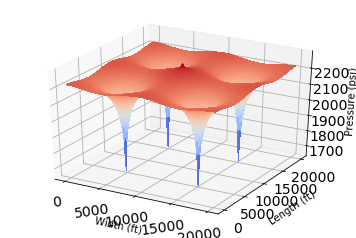

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X.T, Y.T, P_time_50, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)

ax.set_xlabel('Width (ft)')
ax.set_ylabel('Length (ft)')
ax.set_zlabel('Pressure (psi)')
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=8)
plt.show()


This next section is to recreate a more smooth graph in plotly.  
The 3D interactive graph is available at https://plot.ly/~keedanbarrera/2.  

## 5. Visualize Results: Interactive 3D Plot (Plotly)

This section creates an interactive 3D surface plot using Plotly. You can zoom, rotate, and hover to explore pressure values across the reservoir.

**How to use:**
- Click and drag to rotate the view.
- Hover over the surface to see pressure values at specific locations.
- Use this plot for a more detailed and interactive analysis of reservoir behavior.

In [ ]:
# Modern Plotly usage for local interactive plotting
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import pandas as pd

init_notebook_mode(connected=True)

# Create interactive 3D surface plot
fig = go.Figure(data=[
    go.Surface(z=P_time_50, x=X[0], y=Y[:,0], colorscale='Viridis', colorbar=dict(title='Pressure (psi)'))
])

fig.update_layout(
    title='Nichelik Field Pressure Distribution (Day 50)',
    autosize=False,
    width=700,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='Width (ft)',
        yaxis_title='Length (ft)',
        zaxis_title='Pressure (psi)'
    )
)

iplot(fig)

(99, 99)


## 6. Results Summary & Next Steps

- The plots above show how pressure evolves in the reservoir over time, influenced by well placement and operating conditions.
- Use the interactive plot to explore pressure at different locations and times.

**Next Steps:**
- Adjust simulation parameters or well configurations to model different scenarios.
- Add more wells or change their types (producer/injector) to see the impact.
- Export results for further analysis or reporting.
- Add interactive widgets (e.g., ipywidgets) to change parameters without editing code.
- Modularize code into Python scripts for larger projects or repeated use.
- Add unit tests for core functions if sharing with developers.
- Consider exporting results to CSV or Excel for reporting.
- Share this notebook with colleagues for feedback and collaborative improvements.
- Document any customizations or new features you add for future users.

---

For questions or suggestions, see the README or contact the project maintainer.

### Example: Export Results to CSV

Export the pressure results at a specific time step to a CSV file for further analysis or reporting.

In [ ]:
import pandas as pd

# Export pressure at day 50 to CSV
# (X[0] and Y[:,0] are used as column and index labels)
df_pressure_50 = pd.DataFrame(P_time_50, index=Y[:,0], columns=X[0])
df_pressure_50.to_csv("pressure_day50.csv")
print("Pressure at day 50 exported to pressure_day50.csv")

### Example: Add Interactive Widgets for Parameters

Use ipywidgets to allow users to change simulation parameters without editing code.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

NX_widget = widgets.IntSlider(value=99, min=10, max=200, step=1, description='NX')
NY_widget = widgets.IntSlider(value=99, min=10, max=200, step=1, description='NY')
L_widget = widgets.IntText(value=20000, description='Length (ft)')
W_widget = widgets.IntText(value=20000, description='Width (ft)')
h_widget = widgets.IntText(value=300, description='Height (ft)')

display(NX_widget, NY_widget, L_widget, W_widget, h_widget)

# You can use these widget values in your simulation setup:
# NX = NX_widget.value
# NY = NY_widget.value
# L = L_widget.value
# W = W_widget.value
# h = h_widget.value

### Example: Export Results to Excel

Export the pressure results at a specific time step to an Excel file.

In [ ]:
df_pressure_50.to_excel("pressure_day50.xlsx")
print("Pressure at day 50 exported to pressure_day50.xlsx")